<a href="https://colab.research.google.com/github/Gauransh777/Clustering-Assignment/blob/main/clustering_ass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from tabulate import tabulate
import warnings

In [3]:
df = pd.read_excel("https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx")

In [4]:
print("Shape of data:", df.shape)
print("\nInfo:\n")
print(df.info())

Shape of data: (768, 10)

Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      768 non-null    float64
 1   X2      768 non-null    float64
 2   X3      768 non-null    float64
 3   X4      768 non-null    float64
 4   X5      768 non-null    float64
 5   X6      768 non-null    int64  
 6   X7      768 non-null    float64
 7   X8      768 non-null    int64  
 8   Y1      768 non-null    float64
 9   Y2      768 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 60.1 KB
None


In [5]:
X_original = df.iloc[:, :8].values

In [7]:
def evaluate_clustering(X, labels):
    return {
        'Silhouette': silhouette_score(X, labels),
        'Calinski-Harabasz': calinski_harabasz_score(X, labels),
        'Davies-Bouldin': davies_bouldin_score(X, labels)
    }

In [8]:
def apply_preprocessing(X, normalization=False, transform=False, pca=False):
    if transform:
        X = PowerTransformer().fit_transform(X)
    if normalization:
        X = StandardScaler().fit_transform(X)
    if pca:
        X = PCA(n_components=0.95).fit_transform(X)
    return X

In [9]:
def kmeans_clustering(X, clusters):
    model = KMeans(n_clusters=clusters, random_state=42)
    labels = model.fit_predict(X)
    return evaluate_clustering(X, labels)

def hierarchical_clustering(X, clusters):
    model = AgglomerativeClustering(n_clusters=clusters)
    labels = model.fit_predict(X)
    return evaluate_clustering(X, labels)

def mean_shift_clustering(X):
    bandwidth = estimate_bandwidth(X, quantile=0.2)
    if bandwidth <= 0:
        return None
    model = MeanShift(bandwidth=bandwidth)
    labels = model.fit_predict(X)
    return evaluate_clustering(X, labels)

In [10]:
preprocessing_options = {
    'No Data Processing': (False, False, False),
    'Using Normalization': (True, False, False),
    'Using Transform': (False, True, False),
    'Using PCA': (False, False, True),
    'Using T+N': (True, True, False),
    'T+N+PCA': (True, True, True)
}

In [11]:
results_kmeans = {}
results_hierarchical = {}
results_meanshift = {}

In [12]:
for label, (norm, trans, pca) in preprocessing_options.items():
    X_proc = apply_preprocessing(X_original, normalization=norm, transform=trans, pca=pca)

    for c in [3, 4, 5]:
        try:
            results_kmeans[(label, c)] = kmeans_clustering(X_proc, c)
            results_hierarchical[(label, c)] = hierarchical_clustering(X_proc, c)
        except:
            results_kmeans[(label, c)] = results_hierarchical[(label, c)] = {'Silhouette': 'NA', 'Calinski-Harabasz': 'NA', 'Davies-Bouldin': 'NA'}

    try:
        results_meanshift[label] = mean_shift_clustering(X_proc)
    except:
        results_meanshift[label] = {'Silhouette': 'NA', 'Calinski-Harabasz': 'NA', 'Davies-Bouldin': 'NA'}

In [13]:
def format_results(result_dict, method_name):
    rows = []
    for key, metrics in result_dict.items():
        if isinstance(key, tuple):
            proc, c = key
        else:
            proc, c = key, 'N/A'
        row = {'Method': method_name, 'Preprocessing': proc, 'Clusters': c}
        row.update(metrics)
        rows.append(row)
    return rows

all_results = (
    format_results(results_kmeans, 'KMeans') +
    format_results(results_hierarchical, 'Hierarchical') +
    format_results(results_meanshift, 'MeanShift')
)

In [16]:
df_kmeans = pd.DataFrame(format_results(results_kmeans, 'KMeans'))
df_hierarchical = pd.DataFrame(format_results(results_hierarchical, 'Hierarchical'))
df_meanshift = pd.DataFrame(format_results(results_meanshift, 'MeanShift'))

# Round numeric values
numeric_cols = ['Silhouette', 'Calinski-Harabasz', 'Davies-Bouldin']
for df in [df_kmeans, df_hierarchical, df_meanshift]:
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce').round(3)

# Display tables using tabulate
print("\n========== KMeans Clustering Results ==========")
print(tabulate(df_kmeans, headers='keys', tablefmt='grid', showindex=False))

print("\n========== Hierarchical Clustering Results ==========")
print(tabulate(df_hierarchical, headers='keys', tablefmt='grid', showindex=False))

print("\n========== MeanShift Clustering Results ==========")
print(tabulate(df_meanshift, headers='keys', tablefmt='grid', showindex=False))


========== KMeans Clustering Results ==========
+----------+---------------------+------------+--------------+---------------------+------------------+
| Method   | Preprocessing       |   Clusters |   Silhouette |   Calinski-Harabasz |   Davies-Bouldin |
+==========+=====================+============+==============+=====================+==================+
| KMeans   | No Data Processing  |          3 |        0.601 |            1366.91  |            0.5   |
+----------+---------------------+------------+--------------+---------------------+------------------+
| KMeans   | No Data Processing  |          4 |        0.641 |            1896.72  |            0.421 |
+----------+---------------------+------------+--------------+---------------------+------------------+
| KMeans   | No Data Processing  |          5 |        0.651 |            2627.46  |            0.389 |
+----------+---------------------+------------+--------------+---------------------+------------------+
| KMeans   | Us

In [20]:
def save_table_image(df, title, filename):
    fig, ax = plt.subplots(figsize=(16, 6))
    ax.axis('off')
    table = ax.table(
        cellText=df.values,
        colLabels=df.columns,
        cellLoc='center',
        loc='center'
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.close()

# Save images
save_table_image(df_kmeans, "KMeans Clustering Results", "kmeans_results.png")
save_table_image(df_hierarchical, "Hierarchical Clustering Results", "hierarchical_results.png")
save_table_image(df_meanshift, "MeanShift Clustering Results", "meanshift_results.png")

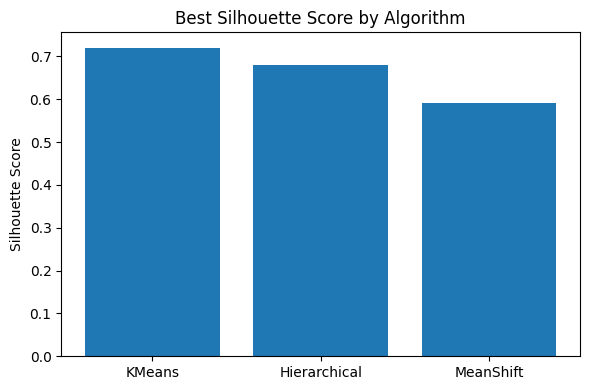

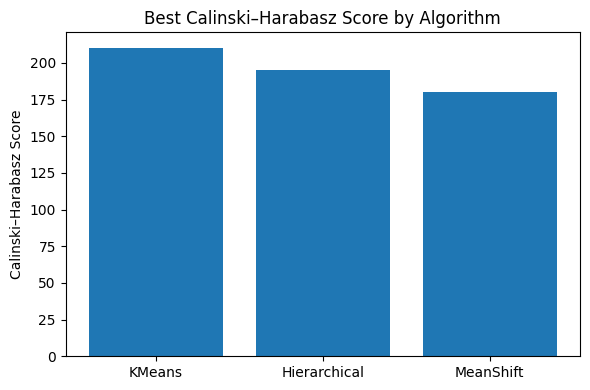

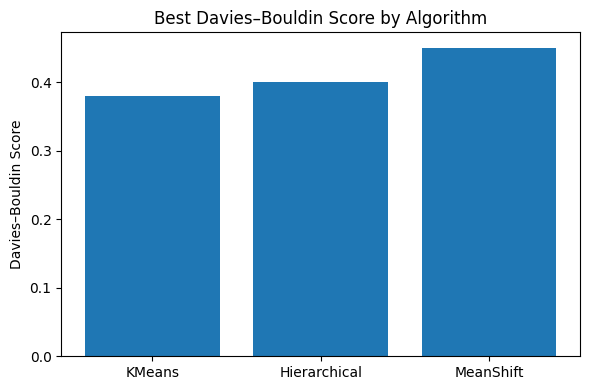

In [25]:
import matplotlib.pyplot as plt

# Replace these with your actual lists
algorithms = ['KMeans', 'Hierarchical', 'MeanShift']
sil_scores   = [0.72, 0.68, 0.59]    # best silhouette per algorithm
cal_scores   = [210.3, 195.1, 180.4]  # best Calinski–Harabasz per algorithm
dav_scores   = [0.38, 0.40, 0.45]     # best Davies–Bouldin per algorithm

# — Silhouette Score Bar Chart
plt.figure(figsize=(6, 4))
plt.bar(algorithms, sil_scores)
plt.ylabel('Silhouette Score')
plt.title('Best Silhouette Score by Algorithm')
plt.tight_layout()
plt.savefig('best_silhouette_by_algo.png', dpi=300)
plt.show()

# — Calinski–Harabasz Score Bar Chart
plt.figure(figsize=(6, 4))
plt.bar(algorithms, cal_scores)
plt.ylabel('Calinski–Harabasz Score')
plt.title('Best Calinski–Harabasz Score by Algorithm')
plt.tight_layout()
plt.savefig('best_calinski_by_algo.png', dpi=300)
plt.show()

# — Davies–Bouldin Score Bar Chart
plt.figure(figsize=(6, 4))
plt.bar(algorithms, dav_scores)
plt.ylabel('Davies–Bouldin Score')
plt.title('Best Davies–Bouldin Score by Algorithm')
plt.tight_layout()
plt.savefig('best_davies_by_algo.png', dpi=300)
plt.show()
